<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>
</center>

# Gestion des données manquantes sur les données d'Ozone avec <a href="https://cran.r-project.org/"><img src="https://cran.r-project.org/Rlogo.svg" style="max-width: 40px; display: inline" alt="R"/></a>

**Résumé**: 
- Création d'un jeu de données contenant des données manquantes à partir des données ozone 
- Visualisation des données manquantes 
- Comparaison de diverses méthodes de complétion pour les données quantitatives
- Complétion avec MissForest de l'ensemble des données (quantitaives et qualitatives) et impact sur les résultats de classification relativement au jeu de données initial complet

## <FONT COLOR="Red">Prise en charge des données </font>

In [1]:
# Chargement des librairies nécessaires
library(ggplot2)


In [6]:
# Chargement des librairies nécessaires pour le traitement des données manquantes
library(missForest)
library(VIM)
library(naniar)

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes :

* **JOUR** : type de jour ; férié (1) ou pas (0) ;
* **O3obs** : concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
* **MOCAGE** : prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
* **TEMPE** : température prévue par MétéoFrance pour le lendemain 17h ;
* **RMH2O** : rapport d'humidité ;
* **NO2** : concentration en dioxyde d'azote ;
* **NO** : concentration en monoxyde d'azote ;
* **STATION** : lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;
* **VentMOD** : force du vent ;
* **VentANG** : orientation du vent. 



### Lecture des données

In [7]:
# 
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- ""
ozone <- read.table(paste(path, "depSeuil.dat", sep = ""),
                    sep = ",", header = TRUE)
# Premières lignes du jeu de données
head(ozone)
# Vérification du contenu
summary(ozone)

,JOUR,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,STATION,VentMOD,VentANG
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,1,91,93.2,21.5,0.00847,1.602,0.424,Aix,9.5000,-0.64350
2,1,100,104.6,20.2,0.00881,2.121,0.531,Aix,8.0100,-0.04996
3,0,82,103.6,17.4,0.00951,1.657,0.467,Aix,9.3771,-0.12832
4,0,94,94.8,18.8,0.00855,2.350,0.701,Aix,9.4578,-0.34516
5,0,107,99.0,23.7,0.00731,1.653,0.452,Aix,7.8791,-0.41822
6,0,150,114.3,23.6,0.01182,5.316,1.343,Aix,6.3127,0.06341


      JOUR            O3obs           MOCAGE          TEMPE      
 Min.   :0.0000   Min.   : 19.0   Min.   : 46.4   Min.   :10.40  
 1st Qu.:0.0000   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20  
 Median :0.0000   Median :109.0   Median :125.6   Median :23.80  
 Mean   :0.3045   Mean   :115.4   Mean   :127.2   Mean   :23.88  
 3rd Qu.:1.0000   3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60  
 Max.   :1.0000   Max.   :319.0   Max.   :284.7   Max.   :38.00  
     RMH2O              NO2               NO           STATION         
 Min.   :0.00285   Min.   : 0.258   Min.   :0.0010   Length:1041       
 1st Qu.:0.00763   1st Qu.: 1.248   1st Qu.:0.2360   Class :character  
 Median :0.00985   Median : 2.109   Median :0.3880   Mode  :character  
 Mean   :0.01025   Mean   : 3.505   Mean   :0.6574                     
 3rd Qu.:0.01244   3rd Qu.: 4.062   3rd Qu.:0.7440                     
 Max.   :0.02753   Max.   :44.396   Max.   :9.4290                     
    VentMOD           VentANG     

In [8]:
# Changement du type des variables qualitatives en facteur
ozone[, "JOUR"] <- as.factor(ozone[, "JOUR"])
ozone[, "STATION"] <- as.factor(ozone[, "STATION"])

In [9]:
# Vérification dans le summary
summary(ozone)

 JOUR        O3obs           MOCAGE          TEMPE           RMH2O        
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Min.   :0.00285  
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   1st Qu.:0.00763  
         Median :109.0   Median :125.6   Median :23.80   Median :0.00985  
         Mean   :115.4   Mean   :127.2   Mean   :23.88   Mean   :0.01025  
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   3rd Qu.:0.01244  
         Max.   :319.0   Max.   :284.7   Max.   :38.00   Max.   :0.02753  
      NO2               NO         STATION      VentMOD       
 Min.   : 0.258   Min.   :0.0010   Aix:199   Min.   : 0.1414  
 1st Qu.: 1.248   1st Qu.:0.2360   Als:222   1st Qu.: 3.9623  
 Median : 2.109   Median :0.3880   Cad:202   Median : 5.5973  
 Mean   : 3.505   Mean   :0.6574   Pla:208   Mean   : 5.9072  
 3rd Qu.: 4.062   3rd Qu.:0.7440   Ram:210   3rd Qu.: 7.1063  
 Max.   :44.396   Max.   :9.4290             Max.   :19.8910  
    VentANG       
 Min.   :-1.570

### Transformations de variables

Des transformations sont proposées pour rendre certaines distributions plus symétriques et ainsi plus "gaussiennes". C'est nécessaire pour certaines méthodes de modélisation ou de complétion des données manquantes. 

In [10]:
ozone[, "SRMH2O"] <- sqrt(ozone[, "RMH2O"])
ozone[, "LNO2"] <- log(ozone[, "NO2"])
ozone[, "LNO"] <- log(ozone[, "NO"])

In [11]:

ozone <- ozone[, c(1:4, 8:13)]

On construit maintenant la variable de dépassement de seuil `DepSeuil` pour obtenir le fichier qui sera effectivement utilisé.

In [12]:
ozone[, "DepSeuil"] <- as.factor(ozone[, "O3obs"] > 150)
summary(ozone)

 JOUR        O3obs           MOCAGE          TEMPE       STATION  
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Aix:199  
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   Als:222  
         Median :109.0   Median :125.6   Median :23.80   Cad:202  
         Mean   :115.4   Mean   :127.2   Mean   :23.88   Pla:208  
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   Ram:210  
         Max.   :319.0   Max.   :284.7   Max.   :38.00            
    VentMOD           VentANG            SRMH2O             LNO2        
 Min.   : 0.1414   Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548  
 1st Qu.: 3.9623   1st Qu.:-0.3948   1st Qu.:0.08735   1st Qu.: 0.2215  
 Median : 5.5973   Median : 0.2783   Median :0.09925   Median : 0.7462  
 Mean   : 5.9072   Mean   : 0.1631   Mean   :0.09957   Mean   : 0.8440  
 3rd Qu.: 7.1063   3rd Qu.: 0.6926   3rd Qu.:0.11153   3rd Qu.: 1.4017  
 Max.   :19.8910   Max.   : 1.5708   Max.   :0.16592   Max.   : 3.7931  
      LNO           

In [13]:
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+xlim(0, 250)+ylim(-150, 150)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

## <FONT COLOR="Red"> [Gestion des données manquantes](http://wikistat.fr/pdf/st-m-app-idm.pdf) </font>



Les vraies données sont le plus souvent mitées par l'absence de données, conséquence d'erreurs de saisie, de pannes de capteurs... Les librairies de R offrent de très nombreux choix pour faire des imputations de données manquantes quand celles-ci le sont de façon complètement aléatoire. 

Plusieurs stratégies sont exécutées et comparées après avoir généré aléatoirement un pourcentage de défaillances (trous) dans les valeurs des variables explicatives.

**Question** Pourquoi la structure des variables explicatives incite-t-elle à exécuter l'algorithme missForest de la librairie éponyme? 

**Dans un premier temps**, nous allons comparer quelques méthodes d'imputation sur les données explicatives quantitatives : LOCF, imputation par la moyenne ou la médiane, kNN, MissForest et Amelia II.


**Dans un deuxième temps**, nous nous concentrerons sur la méthode Missforest et l'objectif sera d'étudier l'impact de l'imputation des données sur les performances de classification pour prédire la variable "depassement de seuil" en comparant deux stratégies :


La **première stratégie** commence par imputer les données manquantes en les prévoyant par l'algorithme MissForest. 

Une fois les données manquantes imputées, différentes méthodes de prévision sont utilisables comme précédemment. Deux sont exécutées: forêts aléatoires et *extrem gradient boosting*.

La **deuxième stratégie** évite l'étape d'imputation en exécutant directement un algorithme de prévision tolérant des données manquantes. Peu d'algorithmes le font, c'est le cas de `XGBoost`.

Attention, les commandes ci-dessous font appel à de nombreux fichiers qu'il est facile de mélanger.
- `X` données complètes initiales et `Xd` la version où les variables qualitatives sont remplacées par des indicatrices, 
- `Xna` les données avec des trous, `Xdna` la version avec indicatrices,

- `XnaImp` les données avec imputations et `XdnaImp` la version avec indicatrices.

Le remplacement des variables qualitatives par des variables indicatrices est imposé par l'utilisation de la librairie `XGBoost` et cela ne change en rien les résultats des forêts aléatoires.

### Préparation des trous dans `ozone`
Les données initiales de la base `ozone` sont reprises. Seule la variable à expliquer de dépassement de seuil est conservée. La librairie `missForest`propose une fonction pour générer un pourcentage fixé a priori de données manquantes dans une base.

In [14]:
# Variable cible
Y=ozone[,"DepSeuil"]
# Variables explicatives
X=ozone[,-c(2,11)]
n=nrow(X); p=ncol(X)
summary(Y); summary(X)

FALSE  TRUE 
  863   178

 JOUR        MOCAGE          TEMPE       STATION      VentMOD       
 0:724   Min.   : 46.4   Min.   :10.40   Aix:199   Min.   : 0.1414  
 1:317   1st Qu.: 97.5   1st Qu.:20.20   Als:222   1st Qu.: 3.9623  
         Median :125.6   Median :23.80   Cad:202   Median : 5.5973  
         Mean   :127.2   Mean   :23.88   Pla:208   Mean   : 5.9072  
         3rd Qu.:153.6   3rd Qu.:27.60   Ram:210   3rd Qu.: 7.1063  
         Max.   :284.7   Max.   :38.00             Max.   :19.8910  
    VentANG            SRMH2O             LNO2              LNO         
 Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548   Min.   :-6.9078  
 1st Qu.:-0.3948   1st Qu.:0.08735   1st Qu.: 0.2215   1st Qu.:-1.4439  
 Median : 0.2783   Median :0.09925   Median : 0.7462   Median :-0.9467  
 Mean   : 0.1631   Mean   :0.09957   Mean   : 0.8440   Mean   :-0.8399  
 3rd Qu.: 0.6926   3rd Qu.:0.11153   3rd Qu.: 1.4017   3rd Qu.:-0.2957  
 Max.   : 1.5708   Max.   :0.16592   Max.   : 3.7931   Max.   : 2.2438  

In [315]:
library(missForest)
# faire une proportion tauxNA de trous aléatoires dans X
# Données missing at random
tauxNa=0.8
set.seed(11)
Xna=prodNA(X,tauxNa)
summary(Xna)

   JOUR         MOCAGE           TEMPE       STATION       VentMOD      
 0   :132   Min.   : 58.80   Min.   :11.60   Aix : 41   Min.   : 0.300  
 1   : 76   1st Qu.: 94.28   1st Qu.:19.60   Als : 49   1st Qu.: 4.000  
 NA's:833   Median :122.40   Median :22.85   Cad : 47   Median : 5.708  
            Mean   :125.84   Mean   :23.37   Pla : 36   Mean   : 5.785  
            3rd Qu.:150.32   3rd Qu.:27.20   Ram : 45   3rd Qu.: 6.935  
            Max.   :284.70   Max.   :37.90   NA's:823   Max.   :17.687  
            NA's   :841      NA's   :837                NA's   :816     
    VentANG            SRMH2O            LNO2              LNO         
 Min.   :-1.5519   Min.   :0.0607   Min.   :-1.2730   Min.   :-2.9565  
 1st Qu.:-0.4939   1st Qu.:0.0867   1st Qu.: 0.1790   1st Qu.:-1.3413  
 Median : 0.1882   Median :0.1007   Median : 0.8078   Median :-0.8783  
 Mean   : 0.0891   Mean   :0.0999   Mean   : 0.8216   Mean   :-0.7878  
 3rd Qu.: 0.6799   3rd Qu.:0.1123   3rd Qu.: 1.3838   3r

**Question** Quel est en moyenne le nombre de données manquantes par colonne?

In [316]:
dim(na.omit(Xna))
NAmoy = tauxNa * length(Xna[,1])
print(paste("On a en moyenne",NAmoy,"NAs par colonne"))

[1] 0 9

[1] "On a en moyenne 832.8 NAs par colonne"


**Question** Serait-il raisonnable de supprimer toutes  les lignes contenant des données manquantes ? Combien resterait-il d'observations ? 

### Visualisation des données manquantes

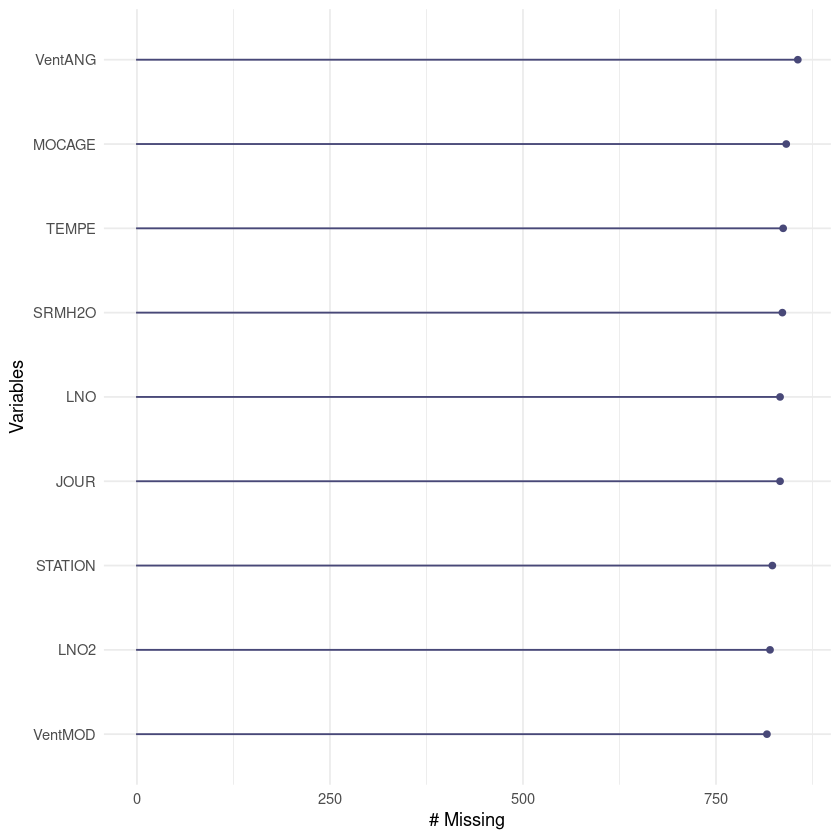

In [317]:
library(naniar)
gg_miss_var(Xna)

In [318]:
library(VIM)


 Variables sorted by number of missings: 
 Variable     Count
  VentANG 0.8222863
   MOCAGE 0.8078770
    TEMPE 0.8040346
   SRMH2O 0.8030740
     JOUR 0.8001921
      LNO 0.8001921
  STATION 0.7905860
     LNO2 0.7877041
  VentMOD 0.7838617


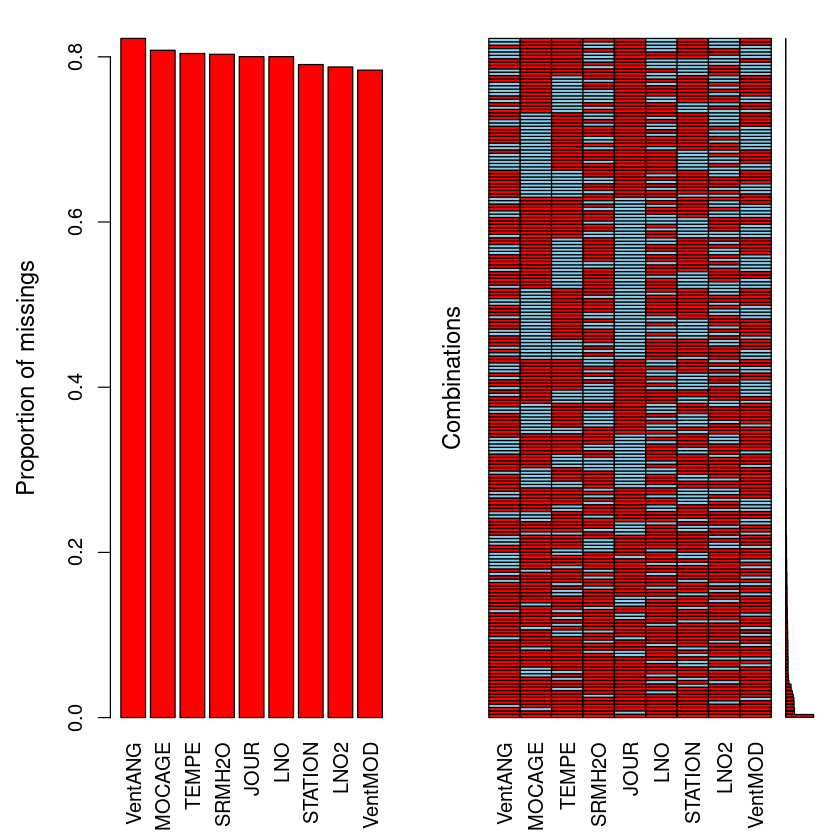

In [319]:
res<-summary(aggr(Xna, sortVar=TRUE))$combinations

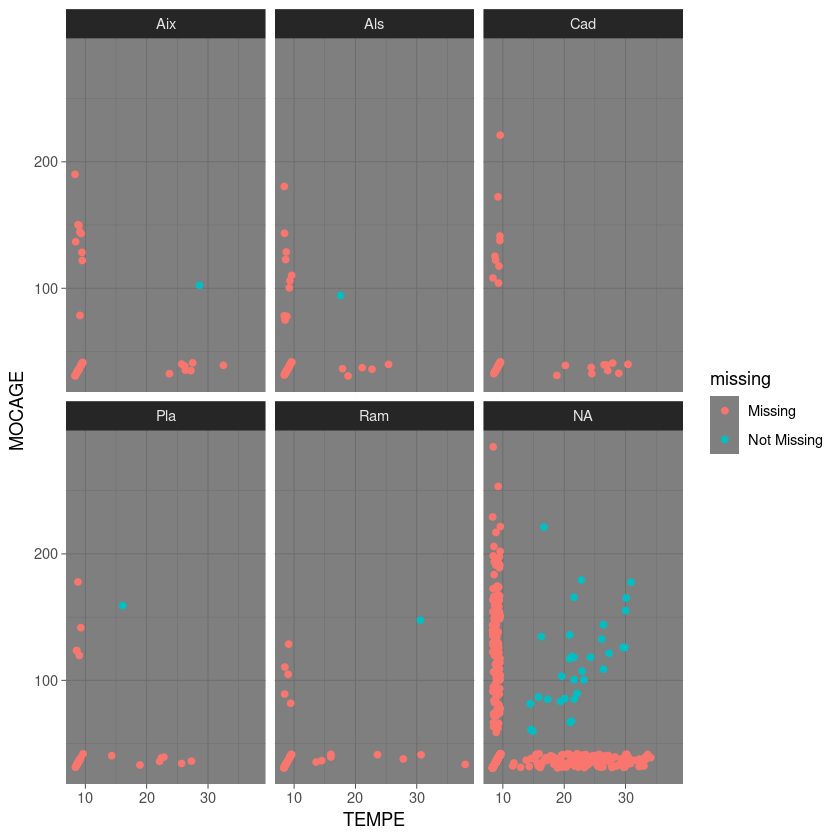

In [320]:
library(ggplot2)
ggplot(Xna, 
       aes(x = TEMPE, 
           y = MOCAGE)) + 
  geom_miss_point() + 
  facet_wrap(~STATION)+ 
  theme_dark()

Permet de voir si les variables manquantes correspondent à une ou plusieurs valeurs en particulier, ou si les NAs sont distribués aléatoirement. (ici, on sait que c'est le cas)



## Comparaison de méthodes d'imputation sur données quantitatives ###

On conserve seulement les variables quantitatives pour comparer diverses méthodes d'imputation.

On compare les différentes méthodes de complétion sur la **variable Temperature**


In [321]:
#Tableau des données quantitatives
#
Xnaquanti=Xna[,-c(1,4)]
Xquanti=X[,-c(1,4)]
ind.na=which(is.na(Xnaquanti),arr.ind=TRUE)
ind.na.Temp=which(is.na(Xnaquanti[,2]),arr.ind=TRUE)
ind.na.Mocage=which(is.na(Xnaquanti[,1]),arr.ind=TRUE)

### Complétion par la dernière valeur connue (LOCF) ####

[1] 4.92725

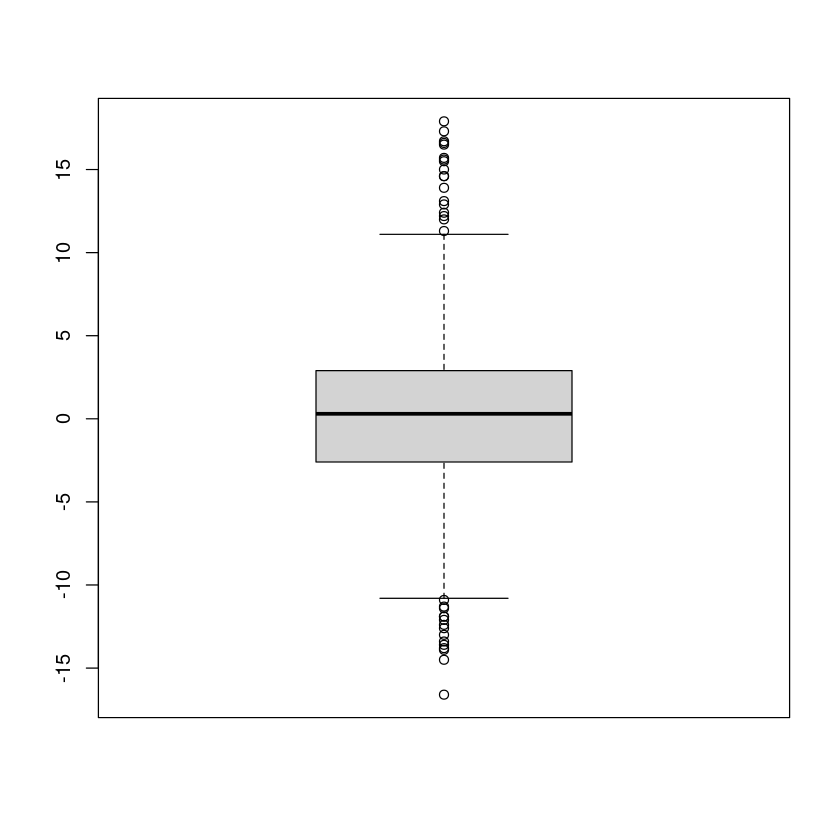

In [322]:
library(zoo) # chargement de la bibliothèque
X.locf=na.locf(Xnaquanti,na.rm=FALSE)
X.locf=na.locf(X.locf,na.rm=FALSE,fromLast=TRUE) # dans l'autre sens
err.locf=(Xquanti-X.locf)[ind.na.Temp,2]
sqrt(mean(err.locf^2))
boxplot(err.locf)

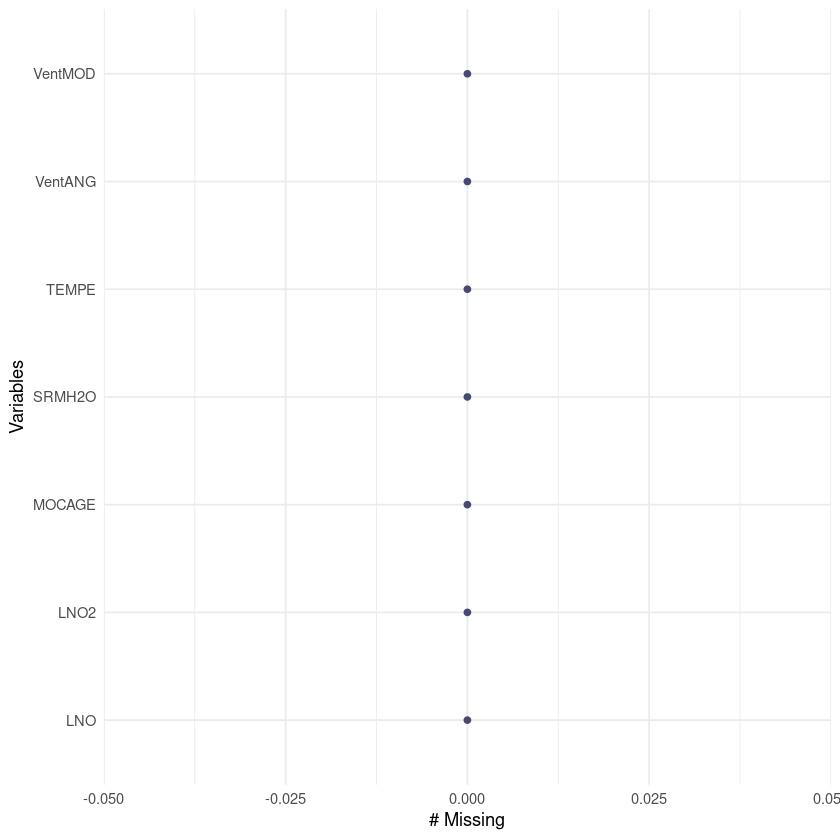

In [323]:
gg_miss_var(X.locf)
# On voit bien qu'on n'a plus aucun NA.

### Complétion par la moyenne ####

[1] 5.231741

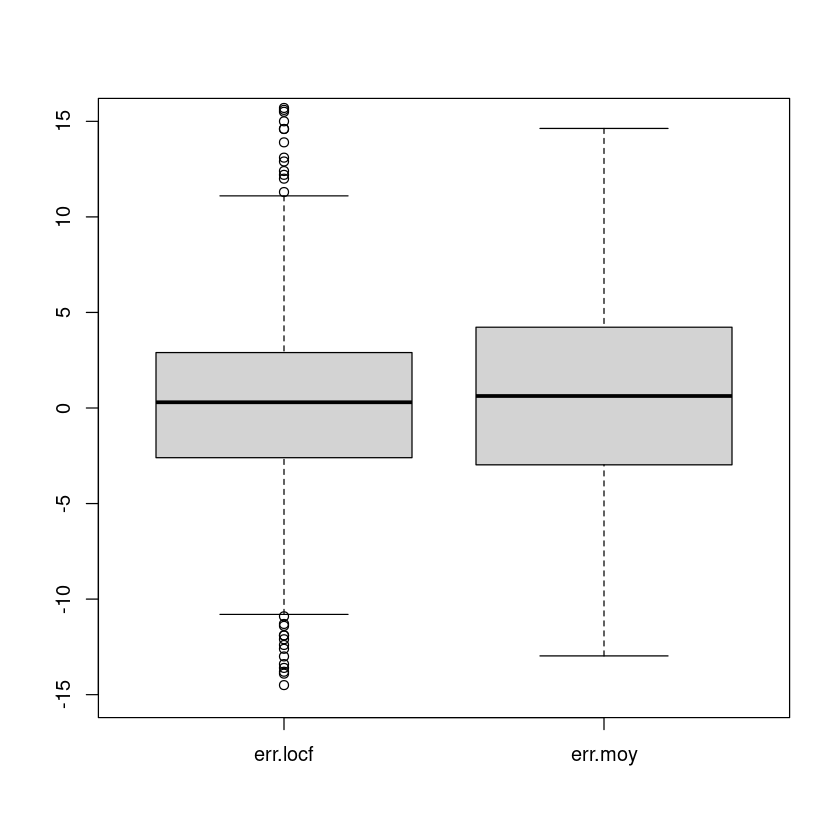

In [324]:
moy=apply(Xnaquanti,2,mean,na.rm=TRUE)
X.moy=Xnaquanti
ind.na=which(is.na(X.moy),arr.ind=TRUE)
X.moy[ind.na]=moy[ind.na[,2]]
err.moy=(Xquanti-X.moy)[ind.na.Temp,2]
sqrt(mean(err.moy^2))
boxplot(data.frame(err.locf,err.moy),ylim=c(-15,15))
# ça a l'air nul

### Complétion par la mediane ####

[1] 5.320542

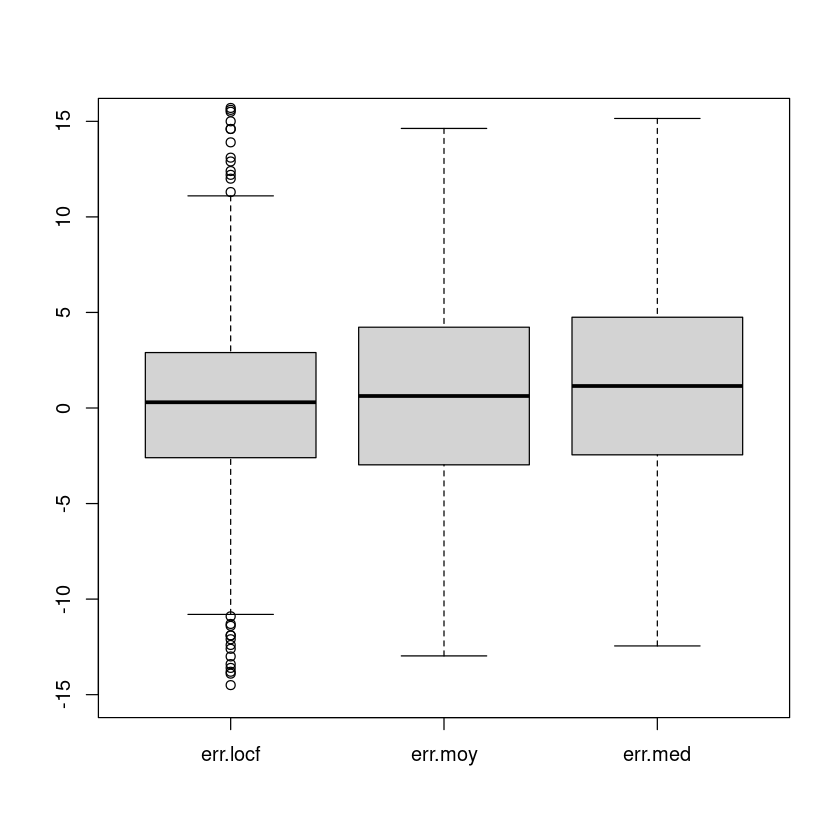

In [325]:

med=apply(Xnaquanti,2,median,na.rm=TRUE)
X.med=Xnaquanti
ind.na=which(is.na(X.med),arr.ind=TRUE)
X.med[ind.na]=med[ind.na[,2]]
err.med=(Xquanti-X.med)[ind.na.Temp,2]

sqrt(mean(err.med^2))
boxplot(data.frame(err.locf,err.moy,err.med),ylim=c(-15,15))
# ça a l'air aussi nul

### Complétion par k plus proches voisins (kNN) ####

[1] 6.484106

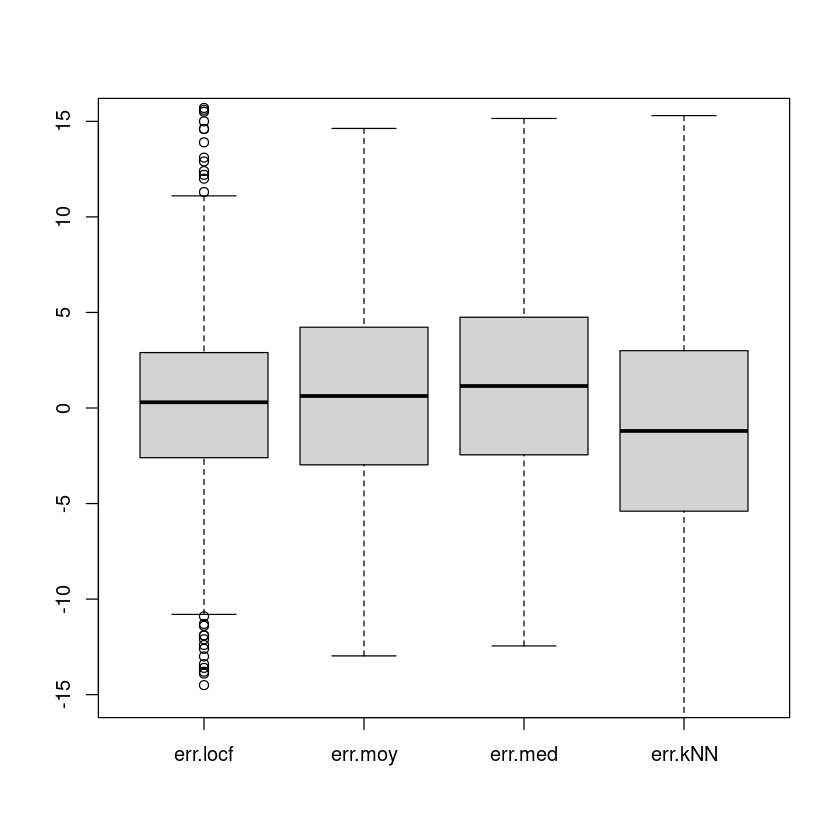

In [326]:
library(VIM) # chargement de la bibliothèque
X.kNN=kNN(Xnaquanti, k=5, imp_var=FALSE)
err.kNN=(Xquanti-X.kNN)[ind.na.Temp,2]
sqrt(mean(err.kNN^2))
boxplot(data.frame(err.locf,err.moy,err.med,err.kNN),ylim=c(-15,15))


### Complétion avec Missforest ####

In [327]:
#help(missForest)

In [328]:
X.mf=missForest(Xnaquanti,xtrue=Xquanti,maxiter=100)

In [329]:
err.mf=(Xquanti-X.mf$ximp)[ind.na.Temp,2]
sqrt(mean(err.mf^2))

[1] 5.804055

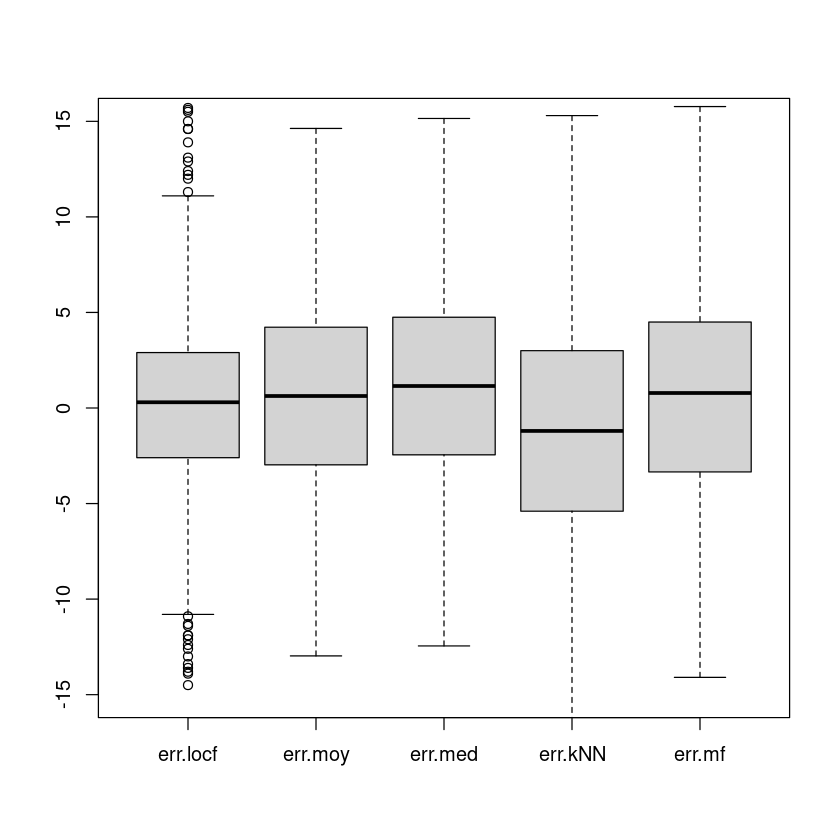

In [330]:

boxplot(data.frame(err.locf,err.moy,err.med,err.kNN,err.mf),ylim=c(-15,15))


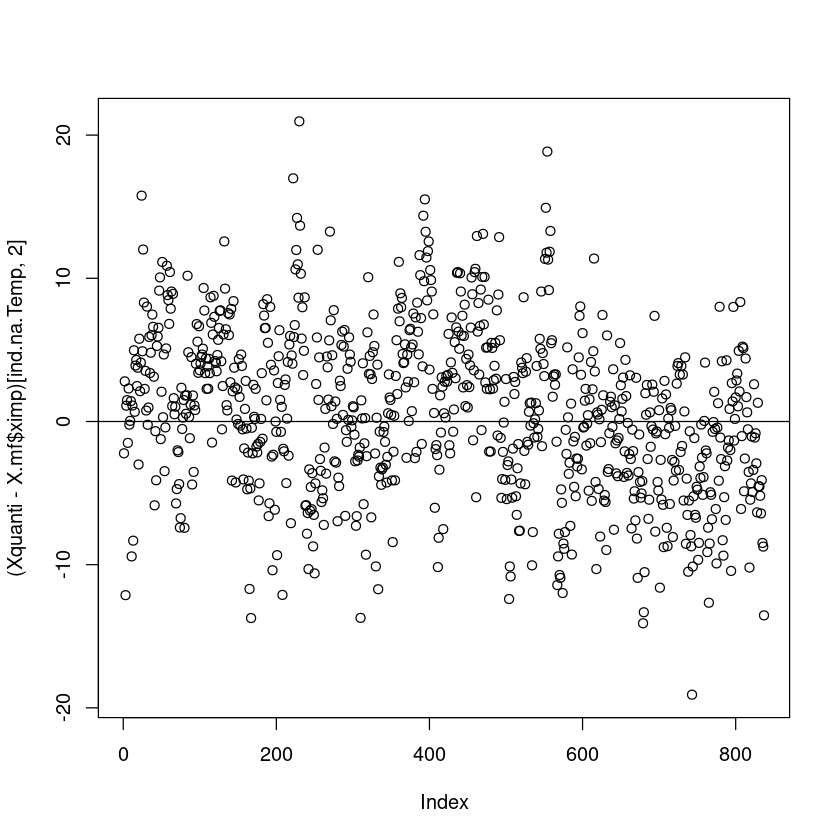

In [331]:
plot((Xquanti-X.mf$ximp)[ind.na.Temp,2])
abline(0,0)

~= graphe des résiudus, analyser la forme et voir si on observe des tendances : phénomènes d'hétéroscédasticité

### Completion avec Amelia II ####

In [332]:
library(Amelia) # chargement de la bibliothèque

In [333]:
install.packages('Amelia')

Installation du package dans ‘/home/richaume/R/libs’
(car ‘lib’ n'est pas spécifié)

Warning message in install.packages("Amelia"):
“l'installation du package ‘Amelia’ a eu un statut de sortie non nul”


In [334]:
#help(amelia)

In [335]:
summary(Xnaquanti)

     MOCAGE           TEMPE          VentMOD          VentANG       
 Min.   : 58.80   Min.   :11.60   Min.   : 0.300   Min.   :-1.5519  
 1st Qu.: 94.28   1st Qu.:19.60   1st Qu.: 4.000   1st Qu.:-0.4939  
 Median :122.40   Median :22.85   Median : 5.708   Median : 0.1882  
 Mean   :125.84   Mean   :23.37   Mean   : 5.785   Mean   : 0.0891  
 3rd Qu.:150.32   3rd Qu.:27.20   3rd Qu.: 6.935   3rd Qu.: 0.6799  
 Max.   :284.70   Max.   :37.90   Max.   :17.687   Max.   : 1.5708  
 NA's   :841      NA's   :837     NA's   :816      NA's   :856      
     SRMH2O            LNO2              LNO         
 Min.   :0.0607   Min.   :-1.2730   Min.   :-2.9565  
 1st Qu.:0.0867   1st Qu.: 0.1790   1st Qu.:-1.3413  
 Median :0.1007   Median : 0.8078   Median :-0.8783  
 Mean   :0.0999   Mean   : 0.8216   Mean   :-0.7878  
 3rd Qu.:0.1123   3rd Qu.: 1.3838   3rd Qu.:-0.2924  
 Max.   :0.1659   Max.   : 3.0610   Max.   : 2.2438  
 NA's   :836      NA's   :820       NA's   :833      

In [336]:
nb_amelia = 10
X.amelia=amelia(Xnaquanti,m=nb_amelia)

         These observations will remain unimputed in the final datasets. 
-- Imputation 1 --

  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80
 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 

In [337]:
summary(X.amelia)


Amelia output with 10 imputed datasets.
Return code:  1 
Message:  Normal EM convergence. 

Chain Lengths:
--------------
Imputation 1:  701
Imputation 2:  432
Imputation 3:  505
Imputation 4:  335
Imputation 5:  831
Imputation 6:  544
Imputation 7:  1473
Imputation 8:  440
Imputation 9:  1077
Imputation 10:  423

Rows after Listwise Deletion:  0 
Rows after Imputation:  825 
Patterns of missingness in the data:  92 

Fraction Missing for original variables: 
-----------------------------------------

        Fraction Missing
MOCAGE         0.8078770
TEMPE          0.8040346
VentMOD        0.7838617
VentANG        0.8222863
SRMH2O         0.8030740
LNO2           0.7877041
LNO            0.8001921



         These observations will remain unimputed in the final datasets. 
-- Imputation 1 --

  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80
 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 

[1] NA

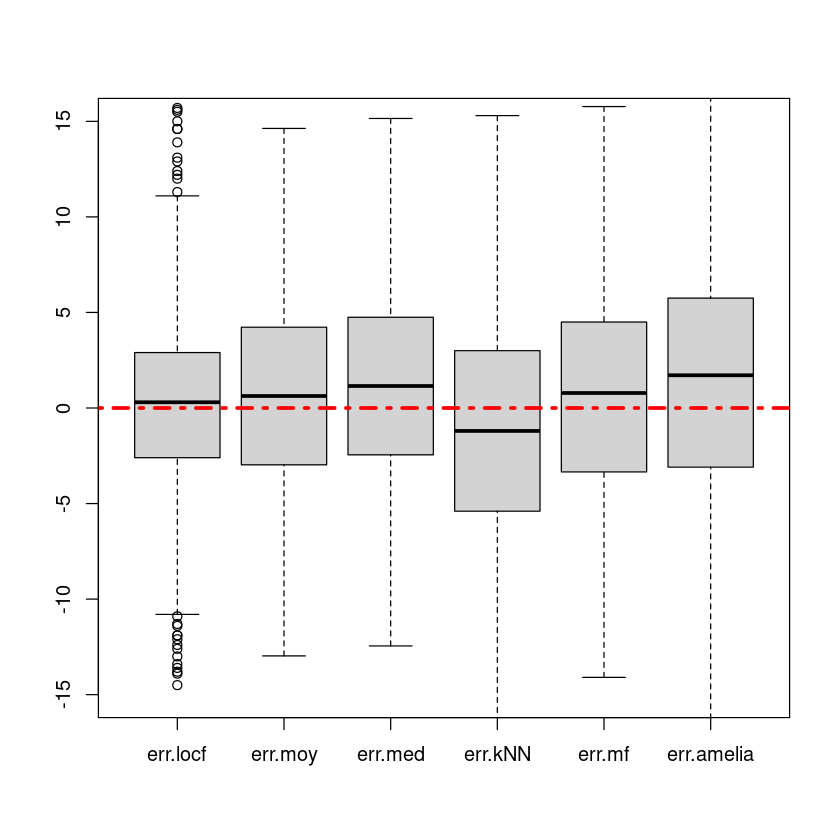

In [338]:
X.amelia=amelia(Xnaquanti,m=5)$imputations$imp1

err.amelia=(Xquanti-X.amelia)[ind.na.Temp,2]

sqrt(mean(err.amelia^2))
boxplot(data.frame(err.locf,err.moy,err.med,err.kNN,err.mf,err.amelia),ylim=c(-15,15))
abline(h=0,col="red",lty=4,lwd=3)

         These observations will remain unimputed in the final datasets. 
-- Imputation 1 --

  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80
 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 

[1] NA

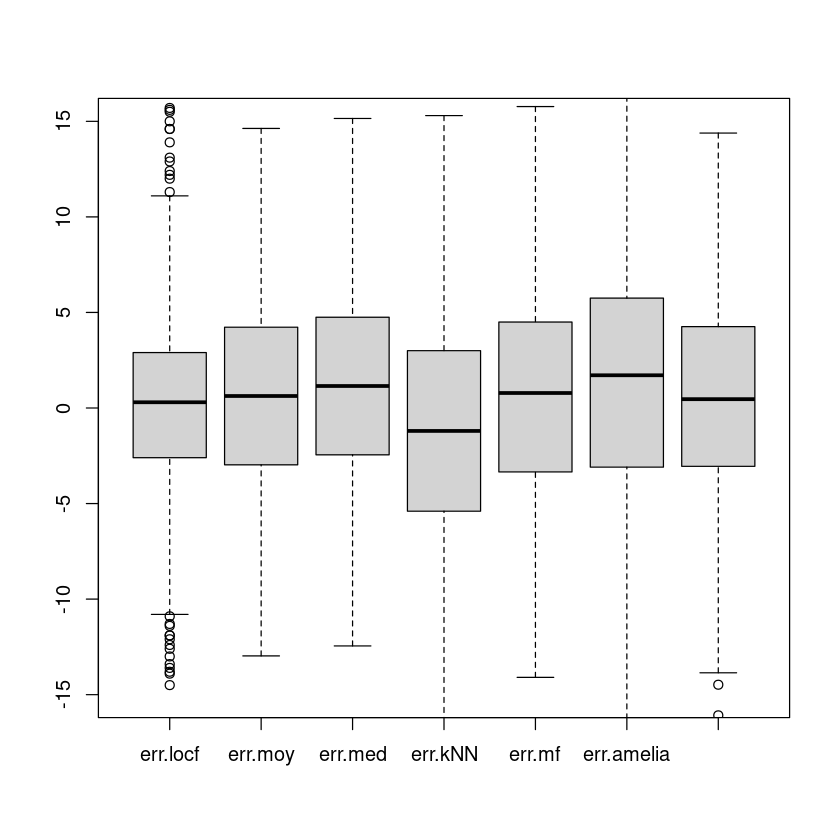

In [339]:
imp = c()

for (i in 1:nb_amelia){
    imp <- append(imp,paste('imp',i, sep=""))
}

X.amelia = amelia(Xnaquanti, m=nb_amelia)

X.amelia.mean = Reduce('+', X.amelia$imputations)/X.amelia$m

err.amelia.mean = (Xquanti-X.amelia.mean)[ind.na.Temp, 2]

sqrt(mean(err.amelia.mean^2))

boxplot(data.frame(err.locf,err.moy,err.med,err.kNN,err.mf,err.amelia, err.amelia.mean),ylim=c(-15,15))

In [340]:
X.amelia = amelia(Xnaquanti,m=nb_amelia)
X.amelia$imputation

         These observations will remain unimputed in the final datasets. 
-- Imputation 1 --

  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80
 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 

MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA,NA,NA
117.49619,21.87011,8.0100000,-0.48196419,0.08050999,0.5331954,-0.63299326
54.46242,27.55432,5.4146576,0.18131953,0.09751923,0.5050087,-0.77784537
94.80000,20.38148,1.8876865,-0.80174643,0.07199796,1.3285398,-0.35524739
182.24892,30.44057,7.8791000,0.69289786,0.10600776,2.1826252,0.18407571
115.51264,27.32408,4.9330688,0.06341000,0.10896619,1.3146946,-0.03651310
127.70000,24.55268,8.8793574,-0.73645778,0.09018418,-0.5641027,-2.07962585
NA,NA,NA,NA,NA,NA,NA
169.51287,24.26709,3.4060659,-0.47517562,0.11287072,2.1755469,0.60690719


**Question** Faire la moyenne des 5 imputations fournies par Amelia. Est-ce que l'on obtient de meilleurs résultats ? 

Les résultats obtenus sont bien meilleurs. On obtient une méthode quasiment aussi performante que LOCF, et on peut même faire varier le nombre d'imputations pour diminuer l'erreur

**Question** Que concluez vous ? Quelle méthode vous semble la plus pertinente sur ces données ? 

## Imputation avec MissForest et impact sur la classification 

### Imputation des données manquantes


On reprend ici le jeu de données complet, incluant les variables explicatives quantitatives et qualitatives. 
L'algorithme missForest permet d'imputer à la fois les variables quantitatives et qualitatives. Revoyez les slides de cours pour son fonctionnement. 

Connaissant les "vraies" données initiales, il est possible, dans ce cas de calculer des erreurs d'imputation de `missForest`.

**Question** Quelles sont elles? Quelle estimation de l'erreur est fournie quand les données manquantes le sont vraiment?

In [341]:
help(missForest)

In [342]:
summary(Xna)
#head(Xna)

   JOUR         MOCAGE           TEMPE       STATION       VentMOD      
 0   :132   Min.   : 58.80   Min.   :11.60   Aix : 41   Min.   : 0.300  
 1   : 76   1st Qu.: 94.28   1st Qu.:19.60   Als : 49   1st Qu.: 4.000  
 NA's:833   Median :122.40   Median :22.85   Cad : 47   Median : 5.708  
            Mean   :125.84   Mean   :23.37   Pla : 36   Mean   : 5.785  
            3rd Qu.:150.32   3rd Qu.:27.20   Ram : 45   3rd Qu.: 6.935  
            Max.   :284.70   Max.   :37.90   NA's:823   Max.   :17.687  
            NA's   :841      NA's   :837                NA's   :816     
    VentANG            SRMH2O            LNO2              LNO         
 Min.   :-1.5519   Min.   :0.0607   Min.   :-1.2730   Min.   :-2.9565  
 1st Qu.:-0.4939   1st Qu.:0.0867   1st Qu.: 0.1790   1st Qu.:-1.3413  
 Median : 0.1882   Median :0.1007   Median : 0.8078   Median :-0.8783  
 Mean   : 0.0891   Mean   :0.0999   Mean   : 0.8216   Mean   :-0.7878  
 3rd Qu.: 0.6799   3rd Qu.:0.1123   3rd Qu.: 1.3838   3r

In [343]:
XnaImp=missForest(Xna,xtrue=X,verbose=TRUE)

  missForest iteration 1 in progress...done!
    error(s): 0.3364487 0.589372 
    estimated error(s): 0.2582194 0.4420872 
    difference(s): 0.01634773 0.3424592 
    time: 0.435 seconds

  missForest iteration 2 in progress...done!
    error(s): 0.348052 0.5948068 
    estimated error(s): 0.2057026 0.2084289 
    difference(s): 0.007203521 0.1032661 
    time: 0.456 seconds

  missForest iteration 3 in progress...done!
    error(s): 0.3635498 0.6020531 
    estimated error(s): 0.1935388 0.2087597 
    difference(s): 0.003810571 0.06099904 
    time: 0.465 seconds

  missForest iteration 4 in progress...done!
    error(s): 0.3621337 0.6032609 
    estimated error(s): 0.1939504 0.2182648 
    difference(s): 0.003449643 0.03506244 
    time: 0.458 seconds

  missForest iteration 5 in progress...done!
    error(s): 0.370437 0.6002415 
    estimated error(s): 0.1901894 0.1967405 
    difference(s): 0.002561396 0.03794428 
    time: 0.459 seconds

  missForest iteration 6 in progress...do

In [344]:
XnaImp$OOBerror;
XnaImp$error
## on s'arrete à l'avant derniere erreur car c'est l'erreur la plus petite ie le moment ou l'erreur augmente 

NRMSE       PFC 
0.1892002 0.2084289

NRMSE       PFC 
0.3726725 0.6032609

Vérifiez que les imputations sont réalisées.

In [345]:
summary(XnaImp$ximp)
#head(XnaImp$ximp)

 JOUR        MOCAGE          TEMPE       STATION      VentMOD      
 0:654   Min.   : 58.8   Min.   :11.60   Aix:184   Min.   : 0.300  
 1:387   1st Qu.:112.0   1st Qu.:21.43   Als:419   1st Qu.: 4.629  
         Median :124.5   Median :22.64   Cad:142   Median : 5.654  
         Mean   :128.8   Mean   :23.47   Pla:146   Mean   : 5.863  
         3rd Qu.:147.6   3rd Qu.:26.12   Ram:150   3rd Qu.: 6.793  
         Max.   :284.7   Max.   :37.90             Max.   :17.687  
    VentANG             SRMH2O             LNO2              LNO         
 Min.   :-1.55193   Min.   :0.06075   Min.   :-1.2730   Min.   :-2.9565  
 1st Qu.:-0.35032   1st Qu.:0.08883   1st Qu.: 0.5872   1st Qu.:-1.1167  
 Median :-0.16057   Median :0.09779   Median : 1.0576   Median :-0.6088  
 Mean   : 0.03386   Mean   :0.09785   Mean   : 0.9414   Mean   :-0.7104  
 3rd Qu.: 0.48167   3rd Qu.:0.10686   3rd Qu.: 1.1831   3rd Qu.:-0.4184  
 Max.   : 1.57079   Max.   :0.16592   Max.   : 3.0610   Max.   : 2.2438  

### Impact sur les performances de classification


On va désormais prédire la variable Depseuil à partir du jeu de données initial (sans valeur manquante) et à partir du jeu de données imputé par missForest afin de comparer les performances de classification. 

On transforme tout d'abord les facteurs en indicatrices.

In [346]:
library(FactoMineR)
# données complètes
Xd=data.frame(tab.disjonctif(X[,c(1,4)]),X[,-c(1,4)])
# données avec trous
Xdna=data.frame(tab.disjonctif(Xna[,c(1,4)]),Xna[,-c(1,4)]) 
# données avec imputations
XdnaImp=data.frame(tab.disjonctif(XnaImp$ximp[,c(1,4)]),XnaImp$ximp[,-c(1,4)]) 

La librairie `caret` facilite beaucoup la syntaxe pour l'exécution, elle est donc reprise. Il faudrait sinon transformer les données sous un autre format. C'est intégré par `caret`.

Construction des mêmes échantillons d'apprentissage et de test dans les trois cas: données initiales, manquantes, imputées.

In [347]:
library(caret)
# parallélisation
library(doParallel)
cl <- makeCluster(4)
registerDoParallel(cl) 
# indices de l’échantillon d’apprentissage
xx=11 # Changer cette valeur pour personnaliser l'échantillonnage
set.seed(xx)

inTrain = createDataPartition(X[,1],p = 0.8, list = FALSE)
# Extraction des échantillons
trainDescr=Xd[inTrain,]
testDescr=Xd[-inTrain,]
# Les mêmes avec trous
trainDescrNA=Xdna[inTrain,]
testDescrNA=Xdna[-inTrain,]
# Les mêmes avec données manquantes imputées
trainDescrNAimp=XdnaImp[inTrain,]
testDescrNAimp=XdnaImp[-inTrain,]
testY=Y[-inTrain]
trainY=Y[inTrain]
cvControl=trainControl(method="cv",number=10)

In [348]:
# prévision avec random forest sur données initiales sans valeurs manquantes
set.seed(2)
rfFit = train(trainDescr, trainY,method = "rf", tuneLength = 8,
              trControl = cvControl, trace=FALSE)

In [349]:

# Prévision avec random forest sur données imputées
set.seed(2)
rfFitNAimp = train(trainDescrNAimp, trainY,method = "rf", tuneLength = 8,
              trControl = cvControl, trace=FALSE)


In [350]:
# Taux de bonnes prévisions sur le test avec données initiales
models=list(rf=rfFit,rfNAimp=rfFitNAimp)

testPred=predict(models, newdata = testDescr)
# taux de bien classés
lapply(testPred,function(x)mean(x==testY))

$rf
[1] 0.8888889

$rfNAimp
[1] 0.826087

**Question** Qu'en déduisez vous sur la qualité des résultats après imputation ? Augmentez le taux de données manquantes (jusqu'à 80 %) pour voir l'impact de ce taux sur la qualité de prédiction après imputation des valeurs manquantes. 


- Pour un taux de NAs de 30%, les prédictions de Depseuil ont une précision entre 0.86 et 0.89, contre 0.89 sans NA. Très satisfaisant !!
- Pour un taux de NAs de 50%, 0.83-0.84
- Pour un taux de NAs de 80%, 0.82

En définitive, miss forest fonctionne très bien pour Depseuil.

### Prévision sans imputation 

La phase d'imputation est rendue obligatoire par l'usage de nombreuses méthodes qui n'acceptent pas les données manquantes. Il peut être intéressant de s'en passer car les informations reconstruites ne sont pas utilisables à d'autres fins; `XGBoost` offre cette oppotunité. Pendant qu'il tourne, [essayer de comprendre](https://arxiv.org/abs/1603.02754) les astuces mises en oeuvre pour tolérer des données manquantes.

In [ ]:
# Prévision avec XGBoost avec données manquantes
install.packages('xgboost')
library(xgboost)

xgbFitNA = train(trainDescrNA, trainY,method = "xgbTree", tuneLength = 6,
               trControl = cvControl)

Installation du package dans ‘/home/richaume/R/libs’
(car ‘lib’ n'est pas spécifié)



In [ ]:
#  Taux de bonnes  prévisions avec XGBoot tolérant les données manquantes.
testPred=predict(xgbFitNA, newdata = testDescrNA)
mean(testPred==testY)

**Question** Comparer les résultats obtenus par les différentes stratégies. En tenant compte des temps de calcul, laquelle semble la plus efficace sur ces données. 

*NB* L'utilisation avancée de `XGBoost` nécessite plus de puissance de calcul afin d'affiner le réglage des nombreux paramètres.

**Question** Qu'en serait-il en utlisant Python au lieu de R?

